In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=311b89edb8a26ba8dce385cd43ed46e8a4381f9284c0d7bf81749326f947c385
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')
model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
img_folder = '/content/drive/MyDrive/Yolo_MultiClass_Semantic_Segmentation/full_set_of_images'

In [ ]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = False


if use_precomputed_embeddings:
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('/content/drive/MyDrive/Yolo_MultiClass_Semantic_Segmentation/full_set_of_images/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath).resize((224, 224)) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Images: 598


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
img_emb.shape

torch.Size([598, 512])

In [ ]:
# We have implemented our own, efficient method
# to find high density regions in vector space
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [ ]:
# Add this line to check the number of embeddings
print("Number of embeddings:", img_emb.shape[0])

Number of embeddings: 598


In [ ]:
# Assuming the definition of community_detection function is correct
# Adjust the init_max_size parameter within the community_detection function if necessary
# For example, set it to the number of embeddings if it's less
init_max_size = min(img_emb.shape[0], 598)  # Replace YOUR_DESIRED_MAX_SIZE with your original value

clusters = community_detection(img_emb, threshold=0.9, min_community_size=1, init_max_size=init_max_size)
print("Total number of clusters:", len(clusters))

Total number of clusters: 212




Cluster size: 64


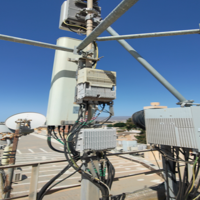

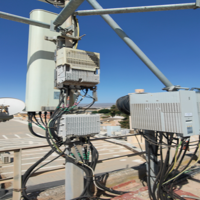



Cluster size: 13


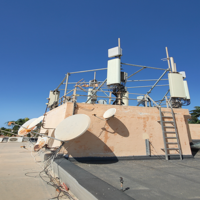

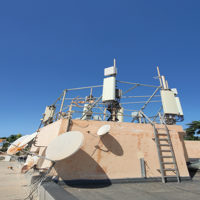



Cluster size: 13


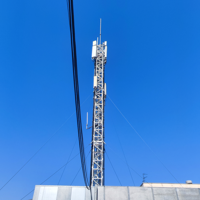

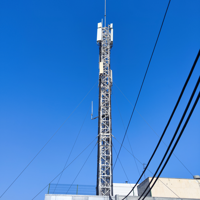



Cluster size: 12


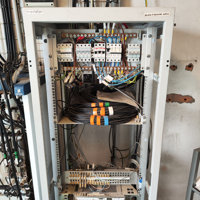

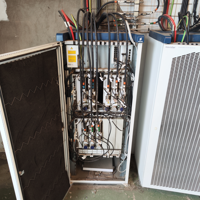



Cluster size: 11


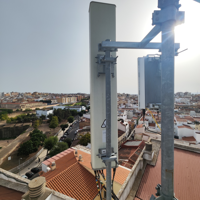

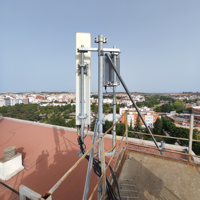



Cluster size: 9


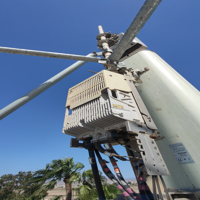

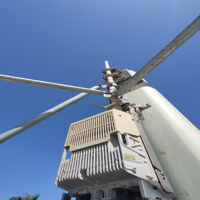



Cluster size: 9


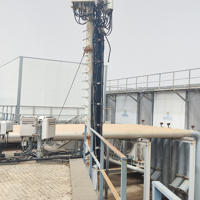

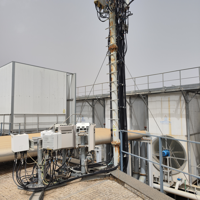



Cluster size: 7


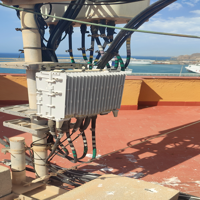

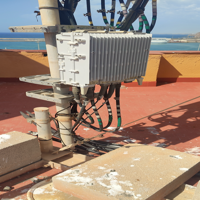



Cluster size: 6


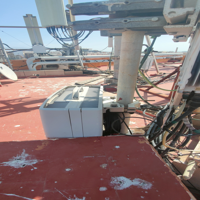

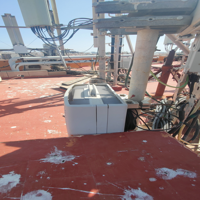



Cluster size: 6


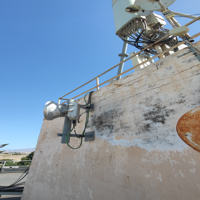

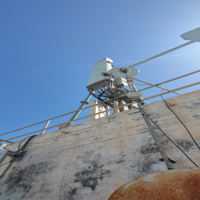



Cluster size: 6


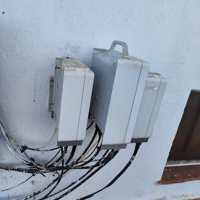

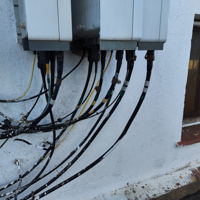



Cluster size: 5


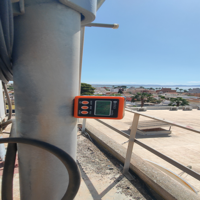

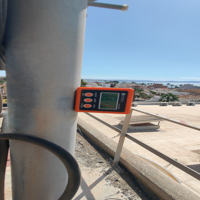

In [ ]:
# Now we output the first 10 (largest) clusters
for cluster in clusters[0:12]:
    print("\n\nCluster size:", len(cluster))

    # Output 3 images with resizing
    for idx in cluster[0:2]:
        img_path = os.path.join(img_folder, img_names[idx])
        with Image.open(img_path) as img:
            img = img.resize((200, 200))  # Resize the image
            display(img)

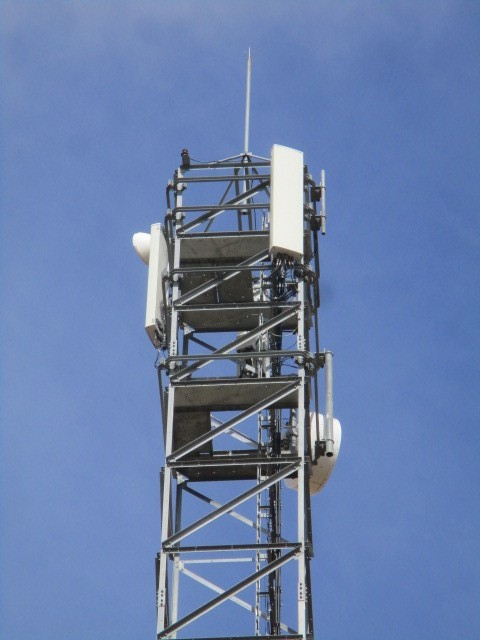

In [ ]:
Image.open('/content/IMG_3767.JPG')

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-re4jx7b7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-re4jx7b7
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=14631f85f5206269b5f7fd57a97d471836fabc9b13fb51c6c6c320b6f1eb86d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6wyvddak/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
from PIL import Image
import torch
import clip

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Open your image and preprocess it for the model
test_image = Image.open('/content/IMG_3767.JPG')
preprocessed_image = preprocess(test_image).unsqueeze(0).to(device)

# Encode the image using the model
test_emb = model.encode_image(preprocessed_image)

# test_emb is now the encoded representation on the GPU

In [ ]:
# Convert both tensors to the same dtype (float32) before computing cosine similarity
test_emb = test_emb.to(dtype=torch.float32)
img_emb = img_emb.to(dtype=torch.float32)

# Compute cosine similarities
cosine_scores = util.cos_sim(test_emb, img_emb)
print(cosine_scores)

tensor([[0.6653, 0.6773, 0.6728, 0.5482, 0.7007, 0.7248, 0.6059, 0.7248, 0.7334,
         0.6800, 0.5937, 0.6766, 0.7014, 0.7282, 0.5441, 0.6844, 0.6696, 0.6636,
         0.6286, 0.6175, 0.6292, 0.6798, 0.6974, 0.6035, 0.7087, 0.6925, 0.5702,
         0.6354, 0.6577, 0.7086, 0.6677, 0.7529, 0.6553, 0.7221, 0.7184, 0.6609,
         0.7028, 0.7329, 0.6545, 0.7437, 0.6616, 0.7479, 0.6934, 0.7308, 0.7635,
         0.6928, 0.6549, 0.7234, 0.7334, 0.7378, 0.7148, 0.6879, 0.7189, 0.6325,
         0.7386, 0.7407, 0.7245, 0.6946, 0.7279, 0.6099, 0.6171, 0.6439, 0.7177,
         0.7097, 0.7527, 0.6909, 0.6875, 0.7020, 0.6698, 0.6852, 0.6376, 0.7162,
         0.7098, 0.7130, 0.6784, 0.6961, 0.6654, 0.6676, 0.7125, 0.6035, 0.7206,
         0.7150, 0.6716, 0.6538, 0.6330, 0.6709, 0.6302, 0.6388, 0.6255, 0.6621,
         0.6283, 0.6767, 0.6384, 0.6883, 0.6055, 0.6462, 0.6359, 0.7449, 0.6218,
         0.6365, 0.6224, 0.6140, 0.7129, 0.7300, 0.6169, 0.7088, 0.7371, 0.7027,
         0.6238, 0.7290, 0.6

In [ ]:
%%time

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores[0])):
    pairs.append({'index': i, 'score': cosine_scores[0][i]})

CPU times: user 7.24 ms, sys: 15 µs, total: 7.26 ms
Wall time: 7.54 ms


In [ ]:
len(cosine_scores)

1

In [ ]:
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

In [ ]:
pairs

[{'index': 441,
  'score': tensor(0.8690, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 262,
  'score': tensor(0.8613, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 509,
  'score': tensor(0.8554, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 268,
  'score': tensor(0.8539, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 270,
  'score': tensor(0.8477, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 429,
  'score': tensor(0.8474, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 443,
  'score': tensor(0.8457, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 428,
  'score': tensor(0.8443, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 266,
  'score': tensor(0.8426, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 433,
  'score': tensor(0.8393, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 255,
  'score': tensor(0.8354, device='cuda:0', grad_fn=<SelectBackward0>)},
 {'index': 254,
  'score': tenso

<timed exec>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


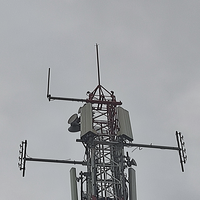

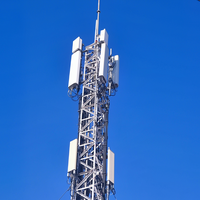

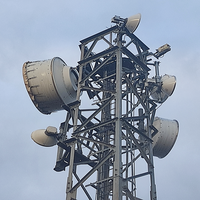

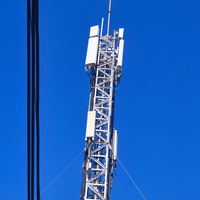

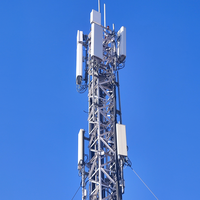

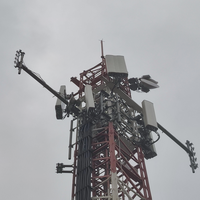

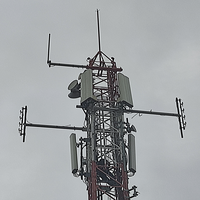

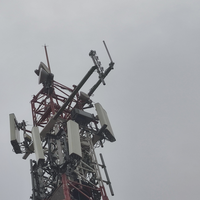

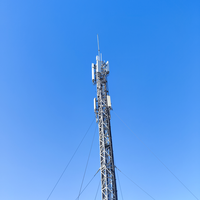

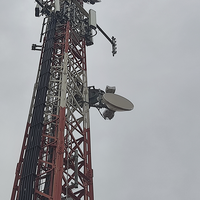

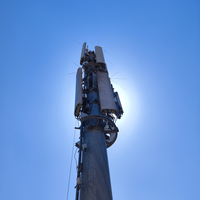

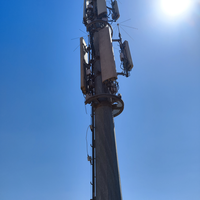

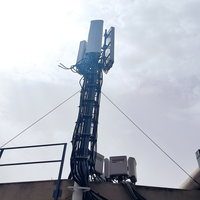

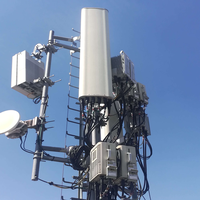

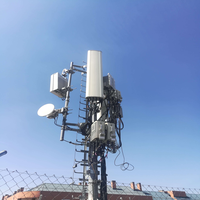

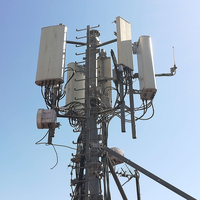

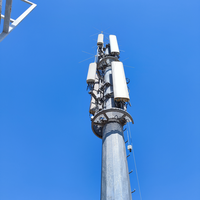

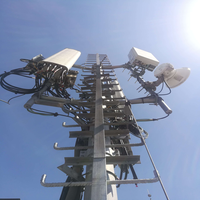

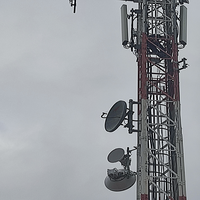

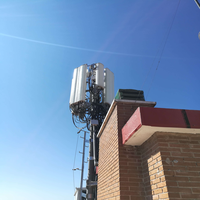

CPU times: user 4.95 s, sys: 255 ms, total: 5.2 s
Wall time: 5.31 s


In [ ]:
%%time

for pair in pairs[0:20]:
    i = pair['index']
    img_path = os.path.join(img_folder, img_names[i])

    with Image.open(img_path) as img:
        # Resize the image
        img = img.resize((200, 200), Image.ANTIALIAS)

        # Display the resized image
        display(img)